# VAE

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
import modelVAE

## 学習データ作成

In [2]:

Dataset = dataset.dataset("Obrid_AE", "data")
Dataset.concat_data("sample_data",500)
Dataset = dataset.dataset("Obrid_AE", "test")
print("----------------------")
Dataset.concat_data("sample_test",100)
print("----------------------")
data = Dataset.read_savedata("sample_test")
print(data.shape[0])
print("----------------------")
# data, test_data , anomaly_data= Dataset.read_traindata("sample_data", "sample_test", 2000, 1024, 1)
data, ori_data, test_data , anomaly_data= Dataset.read_Auged_traindata("sample_data", "sample_test", 1000, 512, 1)


(500, 256)
(500, 256)
----------------------
(100, 256)
(100, 256)
----------------------
(100, 256)
100
----------------------
(500, 256)
(100, 256)
1148 0
rate 0.9
data.shape[0]: 500
rate 450
TrainData (10, 512, 1, 1, 256)
TestData (50, 256)
ÄnomalyDta (100, 256)


## モデル学習

In [3]:
#netよう
z_dim = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = modelVAE.VAE_cnn_drop_net(z_dim, device).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)
input_data = torch.from_numpy(data.astype(np.float32)).clone()
ori_data = torch.from_numpy(ori_data.astype(np.float32)).clone()
input_test_data = torch.from_numpy(test_data.astype(np.float32)).clone()

model.train()
loss_list = []
cnt = 0
# input_data = input_data[0:300]
for epoch in input_data:
    losses = []
    cnt += 1
    for x in epoch:
        x = x.to(device) # データをGPUにのせる
        loss, z, y = model(x, device) # 損失関数の値 loss 、潜在ベクトル z 、再構築画像 y を出力
        model.zero_grad() # モデルの勾配を初期化
        loss.backward() # モデル内のパラメータの勾配を計算
        optimizer.step() # 最適化を実行
        losses.append(loss.cpu().detach().numpy()) # ミニバッチの損失を記録
    loss_list.append(np.average(losses)) # バッチ全体の損失を登録
    print("EPOCH: {} loss: {}".format(cnt, np.average(losses)))
    # for x in input_test_data:
    #     KL_loss, reconstruction_loss = model.loss(x)
    #     loss = KL_loss + reconstruction_loss
    #     losses_val.append(loss.cpu().detach().numpy())

    # print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf' %
    #     (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses)))

EPOCH: 1 loss: 121.64108276367188
EPOCH: 2 loss: 70.72201538085938
EPOCH: 3 loss: 23.2364444732666
EPOCH: 4 loss: 18.110614776611328
EPOCH: 5 loss: 10.050198554992676
EPOCH: 6 loss: 21.946277618408203
EPOCH: 7 loss: 26.67868995666504
EPOCH: 8 loss: 23.29056167602539
EPOCH: 9 loss: 18.749591827392578
EPOCH: 10 loss: 8.213204383850098


In [4]:
# z_dim = 8
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = modelVAE.VAE_cnn(z_dim, device).to(device)
# # optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)
# input_data = torch.from_numpy(data.astype(np.float32)).clone()
# input_test_data = torch.from_numpy(test_data.astype(np.float32)).clone()
# for epoch in input_data:
#     losses = []
#     KL_losses = []
#     reconstruction_losses = []
#     model.train()
#     for x in epoch:
#         x = x.to(device)
#         model.zero_grad()
#         KL_loss, reconstruction_loss = model.loss(x)  # lossの各項の計算
#         loss = KL_loss + reconstruction_loss  # 和を取ってlossとする
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.detach().numpy())
#         KL_losses.append(KL_loss.detach().numpy())
#         reconstruction_losses.append(reconstruction_loss.detach().numpy())

#     losses_val = []
#     model.eval()
#     # for x in input_test_data:
#     #     KL_loss, reconstruction_loss = model.loss(x)
#     #     loss = KL_loss + reconstruction_loss
#     #     losses_val.append(loss.cpu().detach().numpy())

#     # print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf' %
#     #     (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses)))

## モデルの保存

In [5]:
folder_name = "tyuudenkou"
model_name = "VAE"
ModelEdit = mainmodel.Modeledit(folder_name,model_name)
ModelEdit.save_model(model) 

## 確認だよーん

tensor([[[0.2546, 0.1932, 0.1952, 0.1952, 0.1823, 0.1816, 0.1932, 0.1952,
          0.1952, 0.1823, 0.1816, 0.1932, 0.1952, 0.1952, 0.1823, 0.1816,
          0.1932, 0.1952, 0.1952, 0.1823, 0.1816, 0.1932, 0.1952, 0.1952,
          0.1823, 0.1816, 0.1932, 0.1952, 0.1952, 0.1823, 0.1816, 0.1932,
          0.1952, 0.1952, 0.1823, 0.1816, 0.1932, 0.1952, 0.1952, 0.1823,
          0.1816, 0.1932, 0.1952, 0.1952, 0.1823, 0.1816, 0.1932, 0.1952,
          0.1952, 0.1823, 0.1816, 0.1932, 0.1952, 0.1952, 0.1823, 0.1816,
          0.1932, 0.1952, 0.1952, 0.1823, 0.1816, 0.1932, 0.1952, 0.1952,
          0.1823, 0.1816, 0.1932, 0.1952, 0.1952, 0.1823, 0.1816, 0.1932,
          0.1952, 0.1952, 0.1823, 0.1816, 0.1932, 0.1952, 0.1952, 0.1823,
          0.1816, 0.1932, 0.1952, 0.1952, 0.1823, 0.1816, 0.1932, 0.1952,
          0.1952, 0.1823, 0.1816, 0.1932, 0.1952, 0.1952, 0.1823, 0.1816,
          0.1932, 0.1952, 0.1952, 0.1823, 0.1816, 0.1932, 0.1952, 0.1952,
          0.1823, 0.1816, 0.1932, 0.19

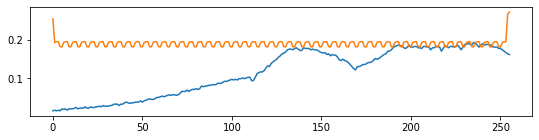

normal:19.104532316327095
anomaly


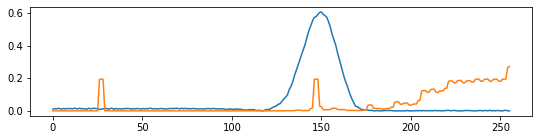

anomarly:24.856868482544087
anomaly
<class 'torch.Tensor'>


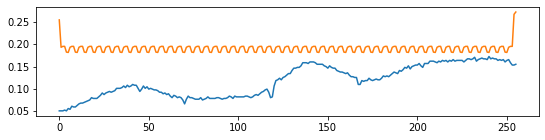

normal:18.635246321558952
anomaly


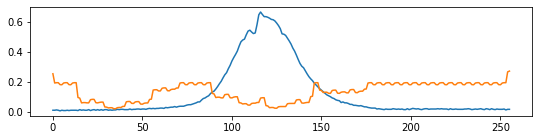

anomarly:43.9071157341823
anomaly
<class 'torch.Tensor'>


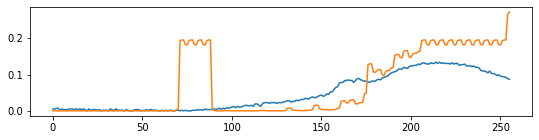

normal:10.688683496171558
anomaly


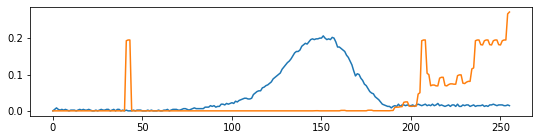

anomarly:16.737536287137388
anomaly
<class 'torch.Tensor'>


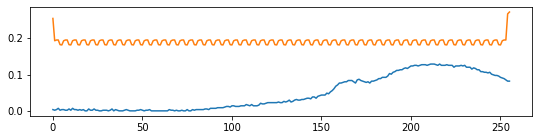

normal:36.59866114705801
anomaly


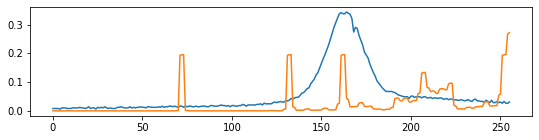

anomarly:14.200841684825718
anomaly
<class 'torch.Tensor'>


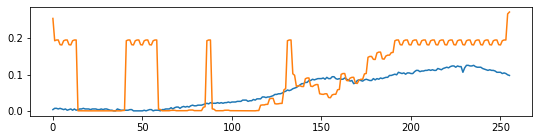

normal:15.247606721960437
anomaly


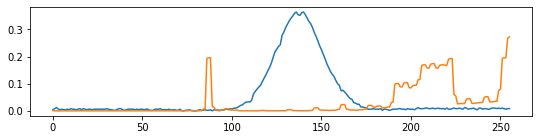

anomarly:19.145576957365847
anomaly
Finish


In [6]:
# num = 5
data0 =  torch.from_numpy((test_data[0]).astype(np.float32)).clone()
data0 = data0[np.newaxis, np.newaxis, :]
loss, z, recon = model(data0, device)
# recon, _ = model(data0)
recon = recon.detach()
print(recon)

for i in range(anomaly_data.shape[0]):
    if i % 10 == 0:
        try:
            data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
            test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
            print(type(data0))
            plt.figure(figsize=(9, 2))
            # data = data0.numpy()
            input_data = data0[np.newaxis, np.newaxis, :]
            # recon,_ = model(input_data)
            loss, z, recon = model(input_data, device)
            recon = recon.detach().numpy()
            plt.plot(data0.numpy())
            plt.plot(recon.flatten())
            plt.show()
            
            anomalypoint=sum(abs(recon.flatten()-data0.numpy()))
            print("normal:"+str(anomalypoint))
            if(anomalypoint>10):
                print("anomaly")
                
            plt.figure(figsize=(9, 2))
            # data = test0.numpy()
            input_data = test0[np.newaxis, np.newaxis, :]
            # recon,_ = model(input_data)
            loss, z, recon = model(input_data, device)
            recon = recon.detach().numpy()
            plt.plot(test0.numpy(),label="testdata")
            plt.plot(recon.flatten(),label="recondata")
            plt.show()
            
            anomalypoint=sum(abs(recon.flatten()-test0.numpy()))
            print("anomarly:"+str(anomalypoint))
            if(anomalypoint>10):
                print("anomaly")
        except IndexError: 
            print("Finish")
            break